<a href="https://colab.research.google.com/github/pedroivovasconcelos/laboratorio_de_controle_ii_chuveiro/blob/master/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install control

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
# Ler os dados do arquivo
filename = 'result1.txt'
tempo = []
entrada = []
saida = []

with open(filename, 'r') as file:
    lines = file.readlines()[1:]
    for line in lines:
        t, e, s, _ = line.strip().split(';')
        tempo.append(float(t)/1000000)
        entrada.append(float(e))
        saida.append(float(s))

# Convertendo listas para numpy arrays
tempo = np.array(tempo)
entrada = np.array(entrada)
saida = np.array(saida)

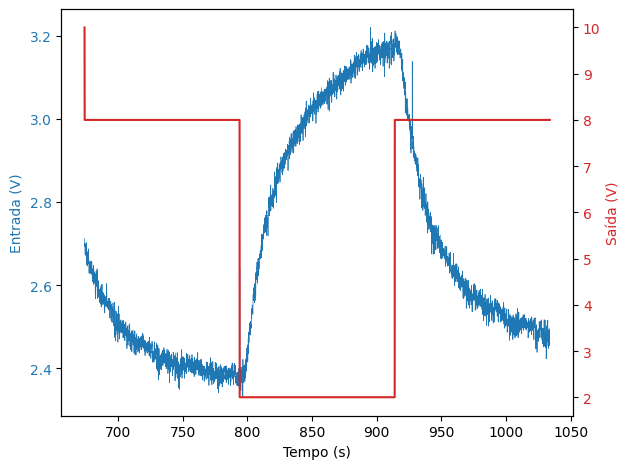

In [16]:
import matplotlib.pyplot as plt

# Plotar os gráficos de entrada e temperatura
fig, ax1 = plt.subplots()

ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Entrada (V)', color='tab:blue')
ax1.plot(tempo, entrada, color='tab:blue', linewidth=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Saída (V)', color='tab:red')
ax2.plot(tempo, saida, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

In [17]:
t0 = 10**8*7.9772
tf = 10**8*9.1599
K = (2.3781-3.1844)/(8-2)
vr = (2.3781-3.1844)*-1*0.632+2.3781
tr = 827831000
tau = (tr - t0)/10**6
print(f"{K},\n{t0},\n{tf},\n{vr},\n{tau}")

-0.13438333333333338,
797720000.0,
915990000.0,
2.8876816,
30.111


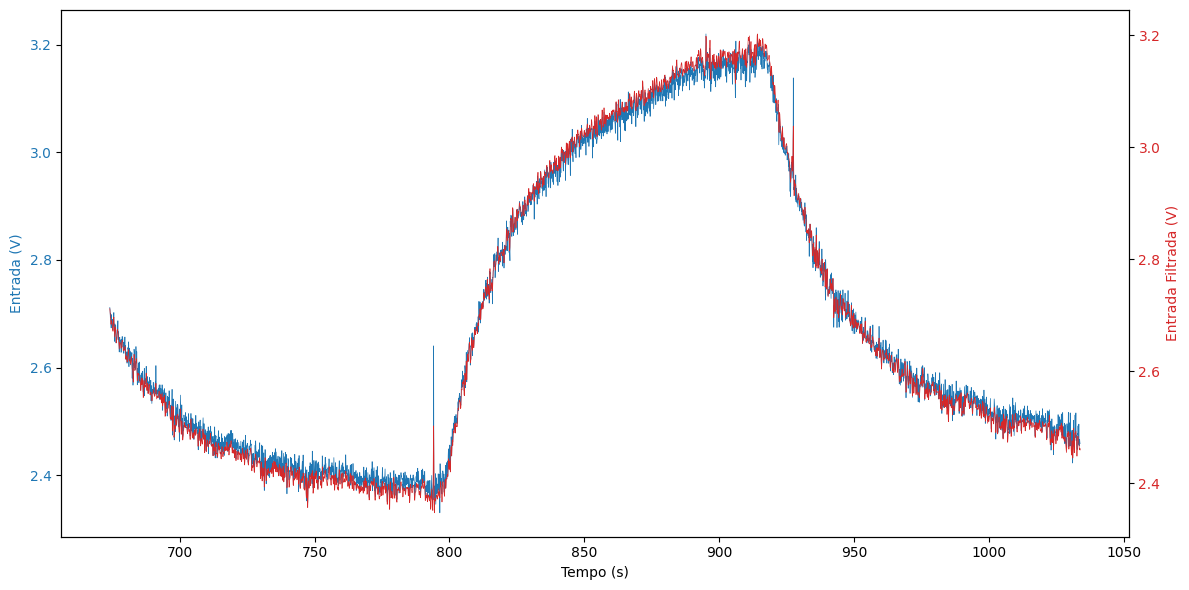

Atraso: -0.10000000000002274, K: 0.999923050698693, tau: -119.90115700000001


In [18]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Função para criar um filtro passa-baixa Butterworth
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Função para aplicar o filtro passa-baixa Butterworth ao sinal
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Aplicar o filtro passa-baixa Butterworth
fs = 2.5  # Frequência de amostragem
cutoff = fs / 4  # Frequência de corte do filtro (escolha um valor adequado)
entrada_filtrada = butter_lowpass_filter(entrada, cutoff, fs)

# Plotar os gráficos de entrada e temperatura
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Entrada (V)', color='tab:blue')
ax1.plot(tempo, entrada, color='tab:blue', linewidth=0.5)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Entrada Filtrada (V)', color='tab:red')
ax2.plot(tempo, entrada_filtrada, color='tab:red', linewidth=0.5)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

# Estimar atraso, K e tau usando o método da curva de reação
degrau_entrada = np.argmax(np.diff(entrada))
degrau_saida = np.argmax(np.diff(entrada_filtrada))
atraso = tempo[degrau_saida] - tempo[degrau_entrada]

K = (entrada_filtrada[-1] - entrada_filtrada[0]) / (entrada[-1] - entrada[0])
tr_index = np.argmax(entrada_filtrada >= 0.632 * (entrada_filtrada[-1] - entrada_filtrada[0]) + entrada_filtrada[0])
tau = tempo[tr_index] - tempo[degrau_saida]

print(f"Atraso: {atraso}, K: {K}, tau: {tau}")

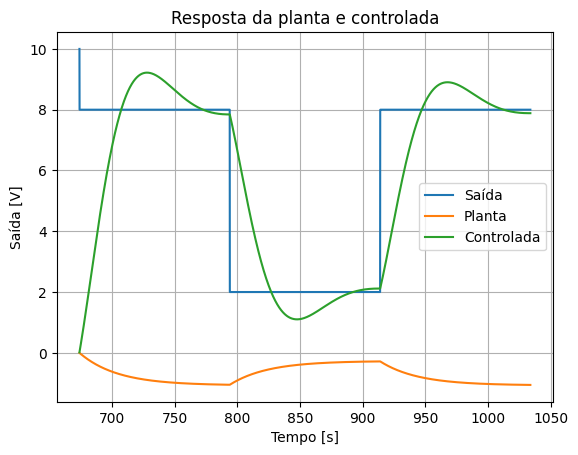

In [23]:
import numpy as np
from control.matlab import *
from scipy.interpolate import interp1d

# Cria uma função de interpolação para a entrada
interp_saida = interp1d(tempo, saida, kind='linear', fill_value='extrapolate')

# Cria um novo vetor de tempo igualmente espaçado
ts = np.mean(np.diff(tempo))
tempo_interp = np.arange(tempo[0], tempo[-1], ts)

# Usa a função de interpolação para obter a entrada correspondente ao novo vetor de tempo
saida_interp = interp_saida(tempo_interp)

# Criando a função de transferência da planta
planta_s = tf([-0.134], [30.111, 1])  # Kp = -0.134, tau = 30.111

# Parâmetros do controlador PI
kp = (1/-0.134) * 0.9
ti = 30.111 * 0.3

# Criando o controlador PI no domínio s
controlador_s = tf([kp*ti, kp], [ti, 0])

# Discretizando a planta e o controlador
ts = np.mean(np.diff(tempo))  # assumindo que tempo é o seu vetor de tempo

planta_z = c2d(planta_s, ts, method='foh')
controlador_z = c2d(controlador_s, ts, method='foh')

# Criando o sistema em malha fechada
system = feedback(series(controlador_z, planta_z), 1)

# Simulando a resposta da planta e da planta controlada
yout_planta, resposta_planta, xout_planta = lsim(planta_z, saida_interp, tempo_interp)
yout_controlada, resposta_controlada, xout_controlada = lsim(system, saida_interp, tempo_interp)

# Plotando as respostas
plt.figure()
plt.plot(tempo_interp, saida_interp, label='Saída')
plt.plot(tempo_interp, yout_planta, label='Planta')
plt.plot(tempo_interp, yout_controlada, label='Controlada')
plt.title('Resposta da planta e controlada')
plt.xlabel('Tempo [s]')
plt.ylabel('Saída [V]')
plt.legend()
plt.grid(True)
plt.show()

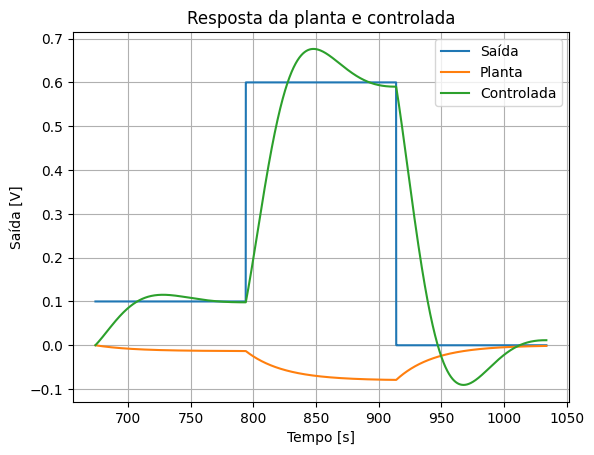

In [27]:
import numpy as np
from control.matlab import *
from scipy.interpolate import interp1d

# Criando um array de degrau para a planta variando de 0.1 até 0.6 e depois em 0
saida_com_degrau = np.repeat([0.1, 0.6, 0], 1200)

# Cria uma função de interpolação para a entrada
interp_saida = interp1d(tempo, saida_com_degrau, kind='linear', fill_value='extrapolate')

# Cria um novo vetor de tempo igualmente espaçado
ts = np.mean(np.diff(tempo))
tempo_interp = np.arange(tempo[0], tempo[-1], ts)

# Usa a função de interpolação para obter a entrada correspondente ao novo vetor de tempo
saida_interp = interp_saida(tempo_interp)

# Criando a função de transferência da planta
planta_s = tf([-0.134], [30.111, 1])  # Kp = -0.134, tau = 30.111

# Parâmetros do controlador PI
kp = (1/-0.134) * 0.9
ti = 30.111 * 0.3

# Criando o controlador PI no domínio s
controlador_s = tf([kp*ti, kp], [ti, 0])

# Discretizando a planta e o controlador
ts = np.mean(np.diff(tempo))  # assumindo que tempo é o seu vetor de tempo

planta_z = c2d(planta_s, ts, method='foh')
controlador_z = c2d(controlador_s, ts, method='foh')

# Criando o sistema em malha fechada
system = feedback(series(controlador_z, planta_z), 1)

# Simulando a resposta da planta e da planta controlada
yout_planta, resposta_planta, xout_planta = lsim(planta_z, saida_interp, tempo_interp)
yout_controlada, resposta_controlada, xout_controlada = lsim(system, saida_interp, tempo_interp)

# Plotando as respostas
plt.figure()
plt.plot(tempo_interp, saida_interp, label='Saída')
plt.plot(tempo_interp, yout_planta, label='Planta')
plt.plot(tempo_interp, yout_controlada, label='Controlada')
plt.title('Resposta da planta e controlada')
plt.xlabel('Tempo [s]')
plt.ylabel('Saída [V]')
plt.legend()
plt.grid(True)
plt.show()

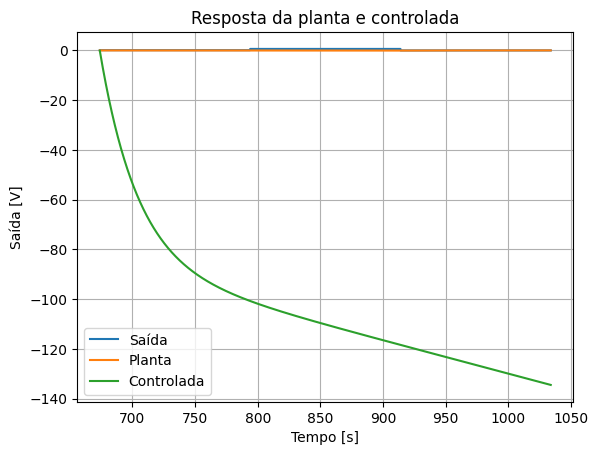

In [31]:
import numpy as np
from control.matlab import *
from scipy.interpolate import interp1d

# Criando um array de degrau para a planta variando de 0.1 até 0.6 e depois em 0
saida_com_degrau = np.repeat([0.1, 0.6, 0], 1200)

# Cria uma função de interpolação para a entrada
interp_saida = interp1d(tempo, saida_com_degrau, kind='linear', fill_value='extrapolate')

# Cria um novo vetor de tempo igualmente espaçado
ts = np.mean(np.diff(tempo))
tempo_interp = np.arange(tempo[0], tempo[-1], ts)

# Usa a função de interpolação para obter a entrada correspondente ao novo vetor de tempo
saida_interp = interp_saida(tempo_interp)

# Criando a função de transferência da planta
planta_s = tf([-0.134], [30.111, 1])  # Kp = -0.134, tau = 30.111

# Parâmetros do controlador PI
kp = (1/-0.134) * 0.9
ti = 30.111 * 0.3

# Criando o controlador PI no domínio s
controlador_s = tf([kp*ti, kp], [ti, 0])

# Discretizando a planta e o controlador
ts = np.mean(np.diff(tempo))  # assumindo que tempo é o seu vetor de tempo

planta_z = c2d(planta_s, ts, method='foh')
controlador_z = c2d(controlador_s, ts, method='foh')

# Criando o sistema em malha fechada
system = feedback(series(controlador_z, planta_z), 1)

# Simulando a resposta da planta e da planta controlada
yout_planta, resposta_planta, xout_planta = lsim(planta_z, saida_interp, tempo_interp)

# Simulando a resposta do controlador à entrada
_, resposta_controlador, _ = lsim(controlador_z, saida_interp, tempo_interp)

# Limitando os valores negativos a 0
resposta_controlador = np.maximum(resposta_controlador, 0)

# Usando a saída limitada do controlador como entrada para o sistema
yout_controlada, _, xout_controlada = lsim(planta_z, resposta_controlador, tempo_interp)

# Plotando as respostas
plt.figure()
plt.plot(tempo_interp, saida_interp, label='Saída')
plt.plot(tempo_interp, yout_planta, label='Planta')
plt.plot(tempo_interp, yout_controlada, label='Controlada')
plt.title('Resposta da planta e controlada')
plt.xlabel('Tempo [s]')
plt.ylabel('Saída [V]')
plt.legend()
plt.grid(True)
plt.show()